## Make 2D embedding of existing, ASR, consensus, and eUniRep designed sequences

Figure 2d

In [1]:
!pip install --upgrade pip
!pip install --upgrade matplotlib

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
  Using cached pip-20.3.4-py2.py3-none-any.whl (1.5 MB)
     |################################| 1.5 MB 17.7 MB/s eta 0:00:01
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
     |################################| 13.0 MB 19.9 MB/s eta 0:00:01
     |################################| 90 kB 13.6 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 2.0.2
    Uninstalling matplotlib-2.0.2:
      Successfully uninstalled matplotlib-2.0.2


In [2]:
import os
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import seaborn as sns

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE

sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils

sys.path.append('../A006_simulated_annealing/')
import A006_common

import A009_common

%reload_ext autoreload
%autoreload 2

In [3]:
test_parents = ['GFPhal', 'muGFP', 'hfriFP', 'TagGFP2', 'GFPxm191uv',
'Superfolder_GFP', 'Folding_Reporter_GFP', 'Ypet', 'TagYFP',
'Clover', 'mClover3', 'Citrine', 'mEmerald', 'mVenus',
'J8VIQ3_9SPHN', 'sfGFP_internal']

parent_names, parent_seqs = A009_common.fasta_read(
    './20181110_filtered_FPBase_Aequorea_FPs_candidates_for_synthesis_alignment.fasta')

test_parent_names = []
test_parent_seqs = []
for i in range(len(parent_names)):
    if parent_names[i] in test_parents:
        test_parent_names.append(parent_names[i])
        test_parent_seqs.append(parent_seqs[i])

parent_df = pd.DataFrame()
parent_df['id'] = parent_names
parent_df['seq'] = parent_seqs
parent_df['annotation'] = 'existing_FP'

display(parent_df.head())

,id,seq,annotation
0,Topaz,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP
1,T-Sapphire,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP
2,H9,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP
3,D10,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP
4,mCitrine,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP


In [4]:
assert set(test_parent_names) == set(test_parents)

In [5]:
md_df = pd.read_csv('A009d_metadata_platemap_merged.csv', index_col=0)
md_df.rename(columns={'Well Location': 'well'}, inplace=True)
print(md_df.shape) # metadata

flow_df = pd.read_csv('A009e_post_chip_1_gfp_colony_pick_flow.csv')


FLOW_COLS_TO_KEEP = ['id', 'seq']

flow_df = flow_df.merge(md_df, on='well', how='left')
flow_df = flow_df[FLOW_COLS_TO_KEEP]

print(flow_df.shape)
display(flow_df.head())

(77, 17)
(80, 2)


,id,seq
0,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...
1,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATIGKLTLKF...
2,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTIKF...
3,GFP_SimAnneal-ET_Global_Init_1-0024-03-3764e94...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLSLKF...


Add an annotation column to the df containing variants we flowed manually.

In [6]:
flow_df['annotation'] = None

for i,r in flow_df.iterrows():
    if isinstance(r['id'], str) and r['id'][:4] == 'GFP_':
        if 'ET_Global_Init_1' in r['id'] or 'ET_Global_Init_2' in r['id']:
            flow_df['annotation'].iloc[i] = 'ET Unirep'
        else:
            flow_df['annotation'].iloc[i] = 'ET Rand Init'
            
    elif isinstance(r['id'], str) and not r['id'][:4] == 'GFP_':
        if 'N11' in r['id'] or 'N1' in r['id']:
            flow_df['annotation'].iloc[i] = 'ASR'
        elif 'consensus_seq' in r['id']:
            flow_df['annotation'].iloc[i] = 'ConSeq'
            
    if not isinstance(r['id'], str):
        flow_df['annotation'].iloc[i] = 'Control'
        
flow_df = flow_df[~flow_df['seq'].isnull()]
        
print(flow_df.shape)
display(flow_df.head())
display(flow_df.tail())

(71, 3)


,id,seq,annotation
0,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,ET Rand Init
1,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATIGKLTLKF...,ET Unirep
2,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTIKF...,ET Unirep
3,GFP_SimAnneal-ET_Global_Init_1-0024-03-3764e94...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ET Unirep
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLSLKF...,ET Unirep


,id,seq,annotation
74,GFP_SimAnneal-ET_Global_Init_2-0096-01-3d7813d...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGMGEGDATYGKMTLKF...,ET Unirep
75,GFP_SimAnneal-ET_Global_Init_2-0096-02-1f121a7...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLNLKF...,ET Unirep
76,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,ET Unirep
77,N1_4_-6.833884__N11_1_-0.180372,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ASR
78,top_consensus_seq,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ConSeq


In [7]:
df = pd.concat([parent_df, flow_df], axis=0)

print(df.shape)
display(df.head())

(141, 3)


,id,seq,annotation
0,Topaz,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP
1,T-Sapphire,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP
2,H9,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP
3,D10,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP
4,mCitrine,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP


## Extract library sequence

In [8]:
df['lib_seq'] = df['seq'].apply(lambda x: x[A006_common.GFP_LIB_REGION[0]:A006_common.GFP_LIB_REGION[1]])

df.head()

,id,seq,annotation,lib_seq
0,Topaz,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP,SGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFGYGVQCFARYP...
1,T-Sapphire,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP,SGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVMVFSRYP...
2,H9,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP,SGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYP...
3,D10,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP,SGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTWGVQCFARYP...
4,mCitrine,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,existing_FP,SGEGEGDATYGKLTLKFILTTGKLPVPWPTLVTTFGYGLMVFARYP...


## Encode and generate 2D embedding

In [9]:
enc_seqs = utils.encode_aa_seq_list_as_matrix_of_flattened_one_hots(list(df['lib_seq']))
print(enc_seqs.shape)

(141, 1620)


In [10]:
DIMRED = MDS

In [11]:
s = DIMRED(n_components=2, random_state=42).fit_transform(enc_seqs)

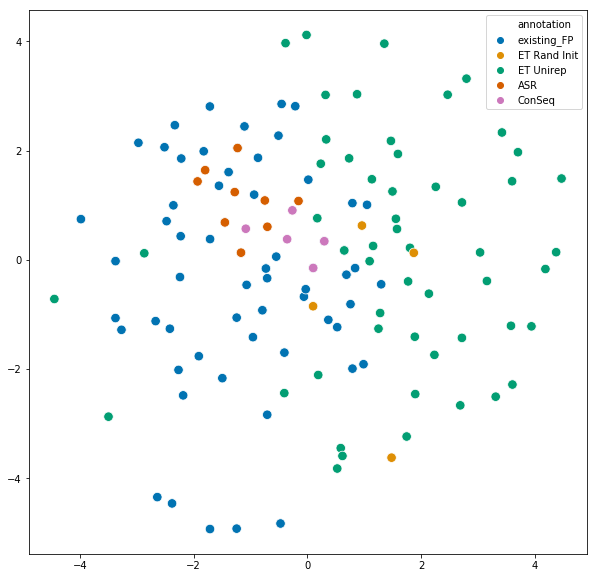

In [12]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=s[:,0], y=s[:,1], hue=df['annotation'], palette='colorblind', s=90)
plt.show()

In [13]:
mds_dist = sklearn.metrics.pairwise_distances(s)
ld_dist = utils.levenshtein_distance_matrix(list(df['lib_seq']))

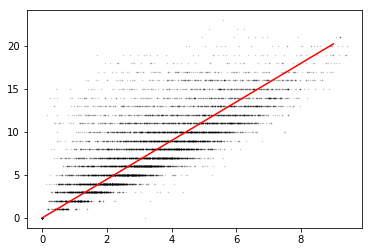

[[1.         0.76959401]
 [0.76959401 1.        ]]
1 MDS unit is 2.25 mutations
1 mutation is 0.44 MDS units


In [14]:
lm = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(mds_dist.reshape((-1,1)), ld_dist.reshape(-1))
xx = np.array([0, 9])

plt.plot(mds_dist.reshape(-1), ld_dist.reshape(-1), '.k', markersize=1, alpha=0.1)
plt.plot(xx, xx*lm.coef_, '-r')
plt.show()


print(np.corrcoef(mds_dist.reshape(-1), ld_dist.reshape(-1)))

print('1 MDS unit is %0.2f mutations' % lm.coef_)
print('1 mutation is %0.2f MDS units' % (1/lm.coef_[0]))

MDS_UNITS_PER_MUTATION = (1/lm.coef_[0])

In [15]:
sns.set_palette(plot_style_utils.CAT_PALETTE)

In [16]:
#uannots = ['existing_FP', 'far but better than wt', 'highly functional', 'ancestral', 'consensus']
uannots = ['existing_FP', 'ET Unirep', 'ASR', 'ConSeq']
bandwidths = [0.3, 0.3, 0.5, 0.5]
alphas = [0.4, 0.4, 0.9, 0.9]

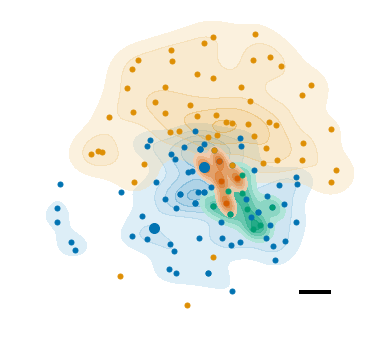

In [17]:
SCALE_BAR_NMUT = 2

fig = plt.figure(figsize=(6,6))
for i,annot in enumerate(uannots):

    mask = df['annotation'] == annot
    sns.kdeplot(s[mask,1], s[mask,0], shade=True, shade_lowest=False, alpha=alphas[i], levels=5, bw=bandwidths[i],
               color=plot_style_utils.CAT_PALETTE[i])
    plt.plot(s[mask,1], s[mask,0], 'o', color=plot_style_utils.CAT_PALETTE[i], markersize=5)
    
av_idx = np.argwhere(df['id'] == 'avGFP_internal').reshape(-1)[0]
plt.plot(s[av_idx,1], s[av_idx,0], 'o', color=plot_style_utils.CAT_PALETTE[0], markersize=10)

sf_idx = np.argwhere(df['id'] == 'sfGFP_internal').reshape(-1)[0]
plt.plot(s[sf_idx,1], s[sf_idx,0], 'o', color=plot_style_utils.CAT_PALETTE[0], markersize=10)

plt.plot([3,3 + SCALE_BAR_NMUT*MDS_UNITS_PER_MUTATION], [-4,-4], '-k', linewidth=4)


plt.axis('off')
plt.show()

plot_style_utils.save_for_pub(fig=fig, path='figures/MDS_plot_of_manually_flowed_designs_and_existing_FPs')

## Median minimum number of mutations

In [18]:
print(df.annotation.value_counts())

existing_FP     70
ET Unirep       53
ASR              9
ConSeq           5
ET Rand Init     4
Name: annotation, dtype: int64


In [19]:
et_unirep_seqs = list(df[df['annotation'] == 'ET Unirep']['lib_seq'])
print(len(et_unirep_seqs))

m = np.logical_or(np.logical_or(df.annotation == 'existing_FP', df.annotation == 'ASR'), df.annotation == 'ConSeq')
non_unirep_seqs = list(df[m]['lib_seq'])
print(len(non_unirep_seqs))

53
84


In [20]:
ld = utils.levenshtein_distance_matrix(et_unirep_seqs, non_unirep_seqs)
print(ld.shape)

(53, 84)


In [21]:
min_dists = np.min(ld, axis=1)
print(np.median(min_dists))

5.0


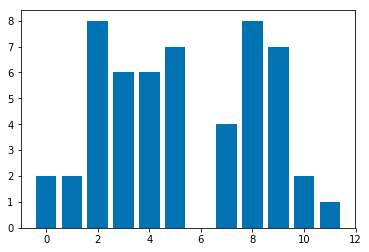

In [22]:
uv, uc = np.unique(min_dists, return_counts=True)
plt.bar(uv,uc)
plt.show()